In [1]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
import h5py
import os.path


import torch.nn.functional as F
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


# Period based data

In [2]:
PATH = "/groups/esm/dzhuang/Catheter/allparam/period/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
inputX_raw = np.load(INPUT_X)
inputY_raw = np.load(INPUT_Y)
inputPara_raw = np.load(INPUT_para)
output_raw = np.load(OUTPUT)

ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50 
n_periods = 10
ncx = ncx1 + ncx2 + ncx3 + ncx4


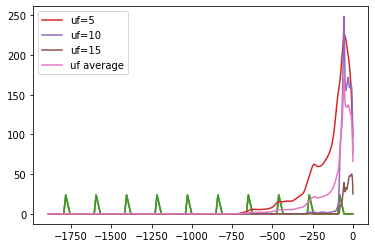

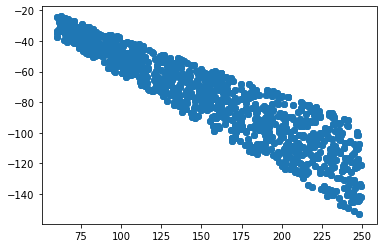

In [4]:
# Combine data
plt.figure()
test_id = 0
plt.plot(inputX_raw[:,3*test_id], inputY_raw[:,3*test_id])
plt.plot(inputX_raw[:,3*test_id+1], inputY_raw[:,3*test_id+1])
plt.plot(inputX_raw[:,3*test_id+2], inputY_raw[:,3*test_id+2])
sample, uf, L_p, x1, x2, x3, h = inputPara_raw[:,3*test_id]

xx = np.linspace(-L_p*n_periods, 0, ncx*n_periods+1)
plt.plot(xx, output_raw[:,3*test_id], label="uf=5")
plt.plot(xx, output_raw[:,3*test_id+1], label="uf=10")
plt.plot(xx, output_raw[:,3*test_id+2], label="uf=15")
plt.plot(xx, (output_raw[:,3*test_id]+output_raw[:,3*test_id+1]+output_raw[:,3*test_id+2])/3, label="uf average")
plt.legend()

plt.figure()
plt.scatter(inputPara_raw[2,:], inputPara_raw[4,:])

In [6]:
ntrain = 800
ntest = 200

batch_size = 20
learning_rate = 0.001
epochs = 501
step_size = 100
gamma = 0.5


modes = n_periods*16
width = n_periods*32
# nx ny
s = n_periods*200 + 1

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0




print("inputX.shape", inputX.shape)
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
print("input shape: n_data, n_p, n_features = ", input.shape)
output = torch.tensor(output, dtype=torch.float).permute(1,0)
print("output shape: n_data, n_p, n_features = ", output.shape)

index = torch.randperm(ntrain+ntest)
train_index = index[:ntrain]
test_index = index[-ntest:]

x_train = input[train_index]
y_train = output[train_index]
x_test = input[test_index]
y_test = output[test_index]
x_train = x_train.reshape(ntrain, s, 2)
x_test = x_test.reshape(ntest, s, 2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size,
                                          shuffle=False)
test_loader2 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1,
                                          shuffle=False)

if __name__ == "__main__":
    ################################################################
    # training and evaluation
    ################################################################
    
    padding=100
    input_channel=2
    output_np=s

    model = FNO1d(modes, width, padding=padding, input_channel=input_channel, output_np=output_np).cuda()
    print(count_params(model))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = LpLoss(size_average=False)

    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            out = model(x)

            loss = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()

        scheduler.step()

        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        train_l2 /= ntrain
        test_l2 /= ntest

        t2 = default_timer()
        print(ep, t2 - t1, train_l2, test_l2)

        # plot
        if ep%step_size==0:
            torch.save(model, 'catheter_plain_period_model_1d'+str(ep))



inputX.shape (2001, 1000)
input shape: n_data, n_p, n_features =  torch.Size([1000, 2001, 2])
output shape: n_data, n_p, n_features =  torch.Size([1000, 2001])
82373057
0 8.435853760689497 0.4561912786960602 0.40617608308792114
1 8.434727642685175 0.3752397173643112 0.36615854501724243
2 8.433161137625575 0.31832800805568695 0.2782714295387268
3 8.430448058992624 0.25924209773540496 0.2828734064102173
4 8.43466477189213 0.23996236979961394 0.2360905337333679
5 8.436940567567945 0.23251083195209504 0.24743343830108644
6 8.431909723207355 0.225988247692585 0.21365222692489624
7 8.432019899599254 0.21458569258451463 0.20617157101631164
8 8.434172273613513 0.21439200580120088 0.22496134042739868
9 8.436759903095663 0.19270039588212967 0.20462072968482972
10 8.434187724255025 0.19385875910520553 0.1804439878463745
11 8.433975921943784 0.17868531972169877 0.18763845324516296
12 8.437781946733594 0.18525025844573975 0.19890808939933777
13 8.434449845924973 0.17876711785793303 0.18412181496620

# Length based data

In [7]:
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
inputX_raw = np.load(INPUT_X)
inputY_raw = np.load(INPUT_Y)
inputPara_raw = np.load(INPUT_para)
output_raw = np.load(OUTPUT)

L_x = 1000
N_s, L_x = 2001, 1000


Text(0, 0.5, 'x3')

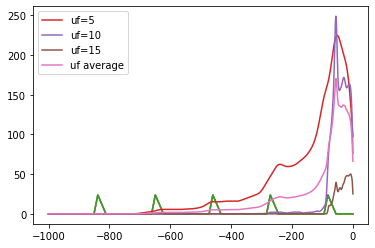

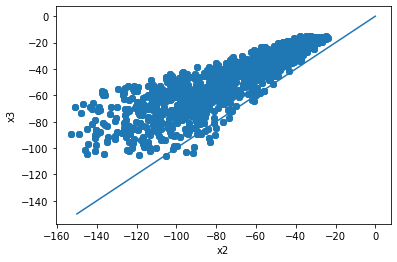

In [12]:
# Combine data
plt.figure()
test_id = 0
plt.plot(inputX_raw[:,3*test_id], inputY_raw[:,3*test_id])
plt.plot(inputX_raw[:,3*test_id+1], inputY_raw[:,3*test_id+1])
plt.plot(inputX_raw[:,3*test_id+2], inputY_raw[:,3*test_id+2])
sample, uf, L_p, x1, x2, x3, h = inputPara_raw[:,3*test_id]

xx = np.linspace(-L_x, 0, N_s)
plt.plot(xx, output_raw[:,3*test_id], label="uf=5")
plt.plot(xx, output_raw[:,3*test_id+1], label="uf=10")
plt.plot(xx, output_raw[:,3*test_id+2], label="uf=15")
plt.plot(xx, (output_raw[:,3*test_id]+output_raw[:,3*test_id+1]+output_raw[:,3*test_id+2])/3, label="uf average")
plt.legend()

plt.figure()
plt.plot(np.linspace(-150,0,100), np.linspace(-150,0,100))
plt.scatter(inputPara_raw[4,:], inputPara_raw[5,:])
plt.xlabel("x2")
plt.ylabel("x3")

In [9]:
ntrain = 800
ntest = 200

batch_size = 20
learning_rate = 0.001
epochs = 501
step_size = 100
gamma = 0.5

n_periods = 10
modes = n_periods*16
width = n_periods*32
# nx ny
s = N_s

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0




print("inputX.shape", inputX.shape)
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
print("input shape: n_data, n_p, n_features = ", input.shape)
output = torch.tensor(output, dtype=torch.float).permute(1,0)
print("output shape: n_data, n_p, n_features = ", output.shape)

index = torch.randperm(ntrain+ntest)
train_index = index[:ntrain]
test_index = index[-ntest:]

x_train = input[train_index]
y_train = output[train_index]
x_test = input[test_index]
y_test = output[test_index]
x_train = x_train.reshape(ntrain, s, 2)
x_test = x_test.reshape(ntest, s, 2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size,
                                          shuffle=False)
test_loader2 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1,
                                          shuffle=False)

if __name__ == "__main__":
    ################################################################
    # training and evaluation
    ################################################################
    
    padding=100
    input_channel=2
    output_np=s

    model = FNO1d(modes, width, padding=padding, input_channel=input_channel, output_np=output_np).cuda()
    print(count_params(model))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = LpLoss(size_average=False)

    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            out = model(x)

            loss = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()

        scheduler.step()

        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        train_l2 /= ntrain
        test_l2 /= ntest

        t2 = default_timer()
        print(ep, t2 - t1, train_l2, test_l2)

        # plot
        if ep%step_size==0:
            torch.save(model, 'catheter_plain_length_model_1d'+str(ep))



inputX.shape (2001, 1000)
input shape: n_data, n_p, n_features =  torch.Size([1000, 2001, 2])
output shape: n_data, n_p, n_features =  torch.Size([1000, 2001])
82373057
0 8.446883142925799 0.5057283186912537 0.3772822713851929
1 8.428866042755544 0.39774727940559385 0.37001331806182863
2 8.436312238685787 0.4137138259410858 0.3820881605148315
3 8.429609970189631 0.398666718006134 0.3625920557975769
4 8.430776288732886 0.40022042751312253 0.34345469951629637
5 8.43053522799164 0.33486409604549405 0.2942745327949524
6 8.432647856883705 0.26040333151817324 0.21051133871078492
7 8.438262086361647 0.23041916280984878 0.1921629476547241
8 8.432402119971812 0.22020069271326065 0.19915151476860046
9 8.436832432635128 0.21669775754213333 0.18479293704032898
10 8.433036676608026 0.206557557284832 0.1922222363948822
11 8.43131808936596 0.20435801029205322 0.19182080507278443
12 8.429613744840026 0.19677694588899614 0.18454260349273682
13 8.43489448633045 0.20635466694831847 0.1749594759941101
14 